Tutorial from

https://elitedatascience.com/python-machine-learning-tutorial-scikit-learn#step-2

### 1) Import the relevant libraries

In [34]:
#efficient numerical computation
import numpy as np
#easy dataframe handling
import pandas as pd
#sampling helper
from sklearn.model_selection import train_test_split
#preprocessing: scaling, transforming and wrangling
from sklearn import preprocessing
#family of models we'll need:
from sklearn.ensemble import RandomForestRegressor
#cross-validation help
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
#metrics for evaluating our model performance
from sklearn.metrics import mean_squared_error, r2_score
#To save our model for future use
from sklearn.externals import joblib #like pickle but more efficient for larger np arrays


# 2) Data
We’ll be training and tuning a random forest for wine quality (as judged by wine ~~snobs~~ experts) based on traits like acidity, residual sugar, and alcohol concentration.

### Data Source:

http://archive.ics.uci.edu/ml/datasets/Wine

### 3) Load the data

In [2]:
dataset_url = 'http://mlr.cs.umass.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data = pd.read_csv(dataset_url)
data.columns

Index(['fixed acidity;"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"'], dtype='object')

In [3]:
data = pd.read_csv(dataset_url, sep=';')
(data.head(5,))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
data.shape

(1599, 12)

We have 1599 samples and 12 features incl. target feature (quality)

* All the features are numeric (convenient!)

* They have different scales (We should standardize them later)

## 4: Split data into training and test sets

In [5]:
y = data.quality
X = data.drop('quality', axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                   random_state=123,
                                                   stratify=y)

## 5: Declare data processing steps

### 5.1 Standardize

In [7]:
#fit Transformer API
scaler = preprocessing.StandardScaler().fit(X_train)

In [8]:
#Apply scaler (scaling transformer) to training data
X_train_scaled = scaler.transform(X_train)

#check if scaling worked
print(X_train_scaled.mean(axis=0))
print(sep='\n')
print(X_train_scaled.std(axis=0))

[ 1.16664562e-16 -3.05550043e-17 -8.47206937e-17 -2.22218213e-17
  2.22218213e-17 -6.38877362e-17 -4.16659149e-18 -2.54439854e-15
 -8.70817622e-16 -4.08325966e-16 -1.17220107e-15]

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [9]:
#Apply scaler (scaling transformer) to test data
X_test_scaled = scaler.transform(X_test)
X_test_scaled.std(axis=0) 

#check if scaling worked
print(X_test_scaled.mean(axis=0))
print(sep='\n')
print(X_test_scaled.std(axis=0))

[ 0.02776704  0.02592492 -0.03078587 -0.03137977 -0.00471876 -0.04413827
 -0.02414174 -0.00293273 -0.00467444 -0.10894663  0.01043391]

[1.02160495 1.00135689 0.97456598 0.91099054 0.86716698 0.94193125
 1.03673213 1.03145119 0.95734849 0.83829505 1.0286218 ]


In [10]:
#In Practise we do:
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         RandomForestRegressor(n_estimators=100, random_state=0))

## 6: Declare Hyperparameters to tune

In [11]:
#list tunable hyperparameters
pipeline.get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('randomforestregressor',
   RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
              oob_score=False, random_state=0, verbose=0, warm_start=False))],
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'randomforestregressor': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_stat

In [12]:
hyperparameters = {'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestregressor__max_depth': [None, 5, 3, 1]}

## 7: Tune model using a cross-validation pipeline


Now we're almost ready to dive into fitting our models. But first, we need to spend some time talking about cross-validation.

This is one of the most important skills in all of machine learning because it helps you maximize model performance while reducing the chance of overfitting.

Cross-validation is a process for reliably estimating the performance of a method for building a model by training and evaluating your model multiple times using the same method.

Practically, that "method" is simply a set of hyperparameters in this context.



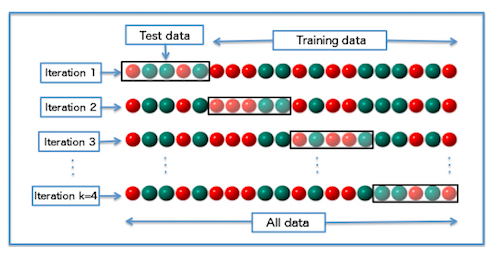

In [13]:
from IPython.display import Image
Image('cross_validation.png')

* Split your data into k equal parts, or "folds" (typically k=10).


* Evaluate it on the remaining "hold-out" fold (e.g. the 10th fold).


* Perform steps (2) and (3) k times, each time holding out a different fold.


* Aggregate the performance across all k folds. This is your performance metric.

The best practice when performing CV is to include your data preprocessing steps inside the cross-validation loop. This prevents accidentally tainting your training folds with influential data from your test fold.

Here's how the CV pipeline looks after including preprocessing steps:

* Split your data into k equal parts, or "folds" (typically k=10).


* Preprocess k-1 training folds.


* Train your model on the same k-1 folds.


* Preprocess the hold-out fold using the same transformations from step (2).


* Evaluate your model on the same hold-out fold.


* Perform steps (2) - (5) k times, each time holding out a different fold.


* Aggregate the performance across all k folds. This is your performance metric.

In [14]:
#skLearn cross-validation with (preprocessing) pipeline 
clf = GridSearchCV(pipeline, hyperparameters, cv=10)

clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decr...mators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'randomforestregressor__max_features': ['auto', 'sqrt', 'log2'], 'randomforestregressor__max_depth': [None, 5, 3, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

* GridSearchCV performs CV across the entire 'grid' (i.e all possible permutations of the hyperparameters


* Takes the model (here we're using a model $\textit{pipeline}$, the hyperparameters to tune, and the number of folds (cv) to create

In [15]:
clf.best_params_

{'randomforestregressor__max_depth': None,
 'randomforestregressor__max_features': 'auto'}

Default parameters are best in this case!

* random forests don't actually require a lot of tuning. They tend to work pretty well out-of-the-box with a reasonable number of trees. Even so, these same steps can be used when building any type of supervised learning model

## 8: Refit on the entire training set

After you've tuned your hyperparameters appropriately using cross-validation, you can generally get a small performance improvement by refitting the model on the entire training set.


Conveniently, GridSearchCV from sklearn will automatically refit the model with the best set of hyperparameters using the entire training set.


This functionality is ON by default, but you can confirm it:


In [36]:
#Confirm model will be retrained on the training set
clf.refit?

In [17]:
clf.refit_time_

2.8209218978881836

Now, you can simply use the  clf object as your model when applying it to other sets of data. That's what we'll be doing in the next step.

## 9: Evaluate model pipeline on test data

In [18]:
y_pred = clf.predict(X_test)

### Now we can use the performance metrics we imported to evaluate our model performance

In [19]:
r2_score(y_test, y_pred)

0.45928349173678806

In [32]:
mean_squared_error(y_test, y_pred)

0.34891

## Is this performance good enough?

Well, the rule of thumb is that your very first model probably won't be the best possible model. However, we recommend a combination of three strategies to decide if you're satisfied with your model performance.

* Start with the goal of the model. If the model is tied to a business problem, have you successfully solved the problem?


* Look in academic literature to get a sense of the current performance benchmarks for specific types of data.


* Try to find low-hanging fruit in terms of ways to improve your model.

There are various ways to improve a model. e.g:

* Try other regression model families (e.g. regularized regression, boosted trees, etc.)


* Collect more data if it's cheap to do so.


* Engineer smarter features after spending more time on exploratory analysis.


* Speak to a domain expert to get more context (...this is a good excuse to go wine tasting!).

## 10: Save model for future use

In [21]:
joblib.dump(clf, 'rf_regressor.pkl')

['rf_regressor.pkl']

In [22]:
clf.score

<bound method BaseSearchCV.score of GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decr...mators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'randomforestregressor__max_features': ['auto', 'sqrt', 'log2'], 'randomforestregressor__max_depth': [None, 5, 3, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)>

In [23]:
type(y_pred)

numpy.ndarray

## Save the predictions from test dataset to csv file:


In [24]:
#y_pred.to_csv('wine_predictions.csv', index=False)

In [25]:
np.savetxt('wine_predictions.csv', y_pred)

In [26]:
check = np.loadtxt('wine_predictions.csv')
#check.head()
check.shape

(320,)

In [27]:
y_test.shape
y_train.shape
X_test.shape

(320, 11)

In [28]:
X_test

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
797,9.3,0.370,0.44,1.60,0.038,21.0,42.0,0.99526,3.24,0.81,10.800000
871,6.9,0.560,0.03,1.50,0.086,36.0,46.0,0.99522,3.53,0.57,10.600000
1333,9.1,0.775,0.22,2.20,0.079,12.0,48.0,0.99760,3.18,0.51,9.600000
1463,6.9,0.630,0.01,2.40,0.076,14.0,39.0,0.99522,3.34,0.53,10.800000
1058,9.9,0.530,0.57,2.40,0.093,30.0,52.0,0.99710,3.19,0.76,11.600000
1130,9.1,0.600,0.00,1.90,0.058,5.0,10.0,0.99770,3.18,0.63,10.400000
1037,7.3,0.910,0.10,1.80,0.074,20.0,56.0,0.99672,3.35,0.56,9.200000
735,7.7,0.965,0.10,2.10,0.112,11.0,22.0,0.99630,3.26,0.50,9.500000
1560,7.8,0.600,0.26,2.00,0.080,31.0,131.0,0.99622,3.21,0.52,9.900000
1224,12.6,0.390,0.49,2.50,0.080,8.0,20.0,0.99920,3.07,0.82,10.300000


# load model from .pkl file
clf2 = joblib.load('rf_regressor.pkl')
 
# Predict data set using loaded model
clf2.predict(X_test)

# Complete code
# 2. Import libraries and modules
import numpy as np
import pandas as pd
 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals import joblib 
 
# 3. Load red wine data.
dataset_url = 'http://mlr.cs.umass.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data = pd.read_csv(dataset_url, sep=';')
 
# 4. Split data into training and test sets
y = data.quality
X = data.drop('quality', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=123, 
                                                    stratify=y)
 
# 5. Declare data preprocessing steps
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         RandomForestRegressor(n_estimators=100))
 
# 6. Declare hyperparameters to tune
hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestregressor__max_depth': [None, 5, 3, 1]}
 
# 7. Tune model using cross-validation pipeline
clf = GridSearchCV(pipeline, hyperparameters, cv=10)
 
clf.fit(X_train, y_train)
 
# 8. Refit on the entire training set
# No additional code needed if clf.refit == True (default is True)
 
# 9. Evaluate model pipeline on test data
pred = clf.predict(X_test)
print r2_score(y_test, pred)
print mean_squared_error(y_test, pred)
 
# 10. Save model for future use
joblib.dump(clf, 'rf_regressor.pkl')
# To load: clf2 = joblib.load('rf_regressor.pkl')
